# 필기체를 구분하는 분류 CNN 구현

1단계 : 분류CNN 모델링

2단계 : 분류CNN을 위한 데이터 준비

3단계 : 학습효과 분석 함수들

4단계 : 분류 CNN 학습 및 성능 평가

## 1. 분류 CNN 모델링

## 1.1. 케라스 패키지 로딩

In [0]:
import keras

from keras import layers, models   #자주사용하는 서브패키지라면 미리 임포트해두고 사용 / 계층과 모델방식
from keras import backend

케라스 패키지로 2가지 모듈 layers, models 를 불러온다.

models-> 각 layer들을 연결하여 신경망 모델을 만든 후 , 컴파일하고 , 학습시키는 역활 -> 서브패키지에 들어 있는 연쇄 방식 모델링 객체 Sequential사용.

models.Model 객체에서 compile(), fit(), predict(), evaluate() 딥러닝 처리 함수 대부분 제공

layers -> 각계층을 만드는 모듈 

layers  패키지에서 Dense, Dropout,  // Flatten, Conv2D, MaxPooling2D

backend 서브패키지 -> 딥러닝 엔진을 직접 제어 / 시스템 파라미터값 참조하거나 변경가능

Conv2D : 2차원 합성곱을 계산하는 클래스
MaxPooling2D : 2차원 맥스풀링을 계산하는 클래스
Flatten : 다차원의 입력을 1차원의 입력으로 변환하는 클래스

## 1.2. 모델 구현



*   분산 방식 모델링 - 함수형 구현
*   연쇄 방식 모델링 - 함수형 구현
* 분산 방식 모델링 - 객체지향형 구현
* **연쇄 방식 모델링 - 객체지향형 구현**

### 1.2.1 연쇄방식 모델링 객체지향형 구현

In [0]:
class CNN(models.Sequential):                                                                   #mo
  def __init__(self, input_shape, num_classes):                                                            #초기화 메서드 
    super().__init__()                                                                          # models.Sequential.init(self)
    self.add(layers.Conv2D(32, kernel_size=(3,3), activation= 'relu', input_shape=input_shape)) #input_shape -> 객체 초기화 변수 // 입력값 모델 인스턴스를 만들때 정해짐. RGB이면 길이가 3인 리스트
    self.add(layers.Conv2D(64, (3,3), activation ='relu'))                                      #커널수 64개  
    self.add(layers.MaxPooling2D(pool_size=(2,2)))                                              #2x2셀묶어서 가장 큰값만 내보내는 부속 계층
    self.add(layers.Dropout(0.25))                                                              #풀링이 끝나면 전체 노드 중 25% 노드의 출력을 끄는 드롭아웃 수행
    self.add(layers.Flatten())                                                                  #입력을 벡터로 변경
    self.add(layers.Dense(128, activation='relu'))                                              #완전연결계층 길이128      //특징점 찾기
    self.add(layers.Dropout(0.5))
    self.add(layers.Dense(num_classes, activation='softmax'))                                   #출력층 분류할 클래스 수   //실질 분류하기
    
    self.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])    

super() 기본 특성을 상속한 부모 함수를 부릅니다. 

super().init()    ==    models.Sequential.__init__(self)



3x3인 커널 32개로 구성 DNN


## 2. 데이터 불러오기



1.   데이터 처리 패키지 임포트
2.   데이터 불러오기
3. 출력값 변수를 이진벡터 형태로 바꾸기
4. 이미지를 나타내는 아규먼트를 1차원 벡터 형태로 바꾸기
5. ANN을 위해 입력값들을 정규화 하기

In [0]:
from keras import datasets

In [0]:
class DATA():
  def __init__(self):
    num_classes = 10
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    img_rows, img_cols = x_train.shape[1:]
    
    print(x_train.shape)
    if backend.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape= (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape= (img_rows, img_cols, 1)
          
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print(x_train.shape)
    
    self.input_shape = input_shape
    self.num_classes = num_classes
    self.x_train, self.y_train = x_train, y_train
    self.x_test, self.y_test = x_test, y_test


## 3. 학습 효과 분석

In [0]:
# from keraspp.skeras import plot_acc, plot_loss
import matplotlib.pyplot as plt

### 3.1 손실을 그리는 함수


In [0]:
def plot_loss(history):
  # history의 loss를 요약
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')

### 3.2 정확도 그리는 함수


In [0]:
def plot_acc(history):
  # history의 acc를 요약
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc=0)

## 4. 분류 CNN 학습 및 성능 평가


In [0]:
def main():
  batch_size = 128
  epochs = 10
  
  data = DATA()
  model = CNN(data.input_shape, data.num_classes)
  
  history = model.fit(data.x_train, data.y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
  
  score = model.evaluate(data.x_test, data.y_test)
  print()
  print('Test loss:',score[0])
  print('Test accuracy:', score[1])
  
  plot_acc(history)
  plt.show()
  plot_loss(history)
  plt.show()

(60000, 28, 28)
(60000, 28, 28, 1)
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 7s 145us/step - loss: 0.2699 - acc: 0.9187 - val_loss: 0.0675 - val_acc: 0.9798
Epoch 2/10
48000/48000 [==============================] - 3s 69us/step - loss: 0.0945 - acc: 0.9730 - val_loss: 0.0524 - val_acc: 0.9847
Epoch 3/10
48000/48000 [==============================] - 3s 69us/step - loss: 0.0694 - acc: 0.9793 - val_loss: 0.0454 - val_acc: 0.9865
Epoch 4/10
48000/48000 [==============================] - 3s 69us/step - loss: 0.0571 - acc: 0.9830 - val_loss: 0.0437 - val_acc: 0.9878
Epoch 5/10
48000/48000 [==============================] - 3s 69us/step - loss: 0.0514 - acc: 0.9845 - val_loss: 0.0429 - val_acc: 0.9882
Epoch 6/10
48000/48000 [==============================] - 3s 69us/step - loss: 0.0454 - acc: 0.9863 - val_loss: 0.0454 - val_acc: 0.9888
Epoch 7/10
48000/48000 [==============================] - 3s 72us/step - loss: 0.0443 - acc:

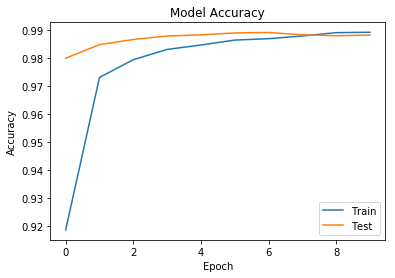

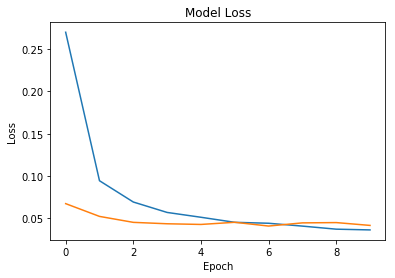

In [87]:
if __name__ == '__main__':
  main()